In [948]:
import argparse
import pandas
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, linregress
import csv
import seaborn as sns
from matplotlib import pyplot as plt
from krippendorff_alpha import krippendorff_alpha, nominal_metric, interval_metric

# Load data

In [949]:
result_csv = "final_results.csv"
las_csv = "las_13_unmatched_simulator_results/LAS_nli_relaxed_unmatched13_test_data_circa_NLI_test.csv"

Load inputs:

In [950]:
inputs1 = pd.read_csv("originalmturk_explain_unmatched.csv", dtype=object)
inputs2 = pd.read_csv("originalmturk_explain_unmatched2.csv", dtype=object)
inputs = pd.concat([inputs1, inputs2])

Load results:

In [951]:
results = pd.read_csv(result_csv, sep=',', dtype=object, escapechar='\\', engine='python',
                      usecols=['WorkerId',
                               'Input.context',
                               'Input.question',
                               'Input.answer',
                               'Input.explanation',
                               'Input.interpretation',
                               'Answer.explanation-quality.label',
                               'WorkTimeInSeconds']
                      )
results.columns = ['WorkerId', 'WorkTimeInSeconds', 'context', 'question',
                   'answer', 'explanation', 'shown_target',
                   'annotation']

Load LAS data:

In [952]:
las = pd.read_csv(las_csv, 
            dtype=object, escapechar='\\', index_col=0
                 )
las.columns = ['context', 'hypothesis', 'answer', 
               'target', 'prediction', 'explanation', 
               'XE_pred','XE_prob','X_pred',
               'X_prob','E_pred','E_prob',
               'leaked']
las.drop(['context'], axis=1, inplace=True)
las.drop(['leaked'], axis=1, inplace=True)

## Clean columns

Make columns numerical:

In [953]:
results['annotation'].replace('5 - very good', 5, inplace=True)
results['annotation'].replace('1 - very poor', 1, inplace=True)
results.annotation = results.annotation.astype(int)
results.WorkTimeInSeconds = results.WorkTimeInSeconds.astype(int)

las['target'] = las['target'].astype(int)
las['prediction'] = las['prediction'].astype(int)
las['XE_pred'] = las['XE_pred'].astype(int)
las['E_pred'] = las['E_pred'].astype(int)
las['X_pred'] = las['X_pred'].astype(int)
las['target'] = las.target.map({0:'Middle', 
                                1:'Yes', 
                                2:'No', 
                                3:'none'
                               })
las['prediction'] = las.prediction.map({0:'Middle', 
                                        1:'Yes', 
                                        2:'No', 
                                        3:'none'
                                       })
las['XE_pred'] = las.XE_pred.map({0:'Middle', 
                                  1:'Yes', 
                                  2:'No', 
                                  3:'none'
                                 })
las['E_pred'] = las.E_pred.map({0:'Middle', 
                                1:'Yes', 
                                2:'No', 
                                3:'none'
                               })
las['X_pred'] = las.X_pred.map({0:'Middle', 
                                1:'Yes', 
                                2:'No', 
                                3:'none'
                               })

Match dataframes:

In [954]:
data = inputs.merge(
        results,
        on=["context", "question", "answer", "explanation"],
        how="right",
)

Add additional information:

In [955]:
data['corr_target_shown'] = data['target'] == data['shown_target']
data = data.replace('In the middle, neither yes nor no', 'Middle')

Drop irrelevant columns and add indicator for correct prediction:

In [956]:
data.drop(['exclude', 
           'goldstandard1', 
           'correct_pred', 
           'interpretation'], axis=1, inplace=True)
data['correct_pred'] = data['target'] == data['prediction']

Merge with LAS data:

In [957]:
data = data.merge(
        las,
        on=["hypothesis", "target", "prediction", "explanation", "answer"],
        how="inner",
)

Add LAS-specific information:

In [958]:
data['XE_correct'] = data['XE_pred'] == data['prediction']
data['E_correct'] = data['E_pred'] == data['prediction']
data['X_correct'] = data['X_pred'] == data['prediction']
data['LAS_score'] = data['XE_correct'].astype(int) - data['X_correct'].astype(int)

Total number of annotations (not yet checked for 3 annotations per item):

In [959]:
len(data)

359

Remove items with less than 3 annotations:

In [960]:
num_annotations = data[['id', 'corr_target_shown', 'WorkerId']].groupby(['id', 'corr_target_shown']).agg({'WorkerId': ['count']})
num_annotations.columns = ['num_annotations']
data = data.merge(num_annotations, how='left', on=['id', 'corr_target_shown'])
data = data[data['num_annotations'] == 3]

Remove wrongly formatted sample identified during the survey:

In [961]:
data = data[data['id'] != '17777']

# Data Statistics

In [962]:
print(f"Unique samples: {len(pd.unique(data['id']))}")

Unique samples: 71


Number of remaining annotations:

In [963]:
len(data)

300

In [964]:
data.columns

Index(['hypothesis', 'answer', 'target', 'prediction', 'explanation', 'leaked',
       'id', 'context', 'question', 'judgements', 'WorkerId',
       'WorkTimeInSeconds', 'shown_target', 'annotation', 'corr_target_shown',
       'correct_pred', 'XE_pred', 'XE_prob', 'X_pred', 'X_prob', 'E_pred',
       'E_prob', 'XE_correct', 'E_correct', 'X_correct', 'LAS_score',
       'num_annotations'],
      dtype='object')

# Analysis

## Worker normalization

The following process normalizes the annotations using the average intra-worker mean 
and the average intra-worker standard deviation. This process ensures that systematic 
differences between workers (e.g. one worker tends to rate lower vs. the other tends 
to rate higher) are removed.

Calculate average intra-worker mean and average intra-worker standard deviation:

In [965]:
annotation_mean = data.groupby(['WorkerId']).agg({'annotation': ['mean']}).mean().to_numpy()[0]
annotation_std = data.groupby(['WorkerId']).agg({'annotation': ['std']}).mean().to_numpy()[0]

Center each annotation with the difference of the intra-worker mean of the worker who annotated it to the average intra-worker mean.

In [966]:
agg_data = data.groupby(['WorkerId']).agg({'annotation': ['mean']})
agg_data.columns = ['worker_mean']
agg_data['mean_diff'] = annotation_mean - agg_data['worker_mean']
agg_data.drop(['worker_mean'], axis=1, inplace=True)
data = data.merge(agg_data, how='left', on=['WorkerId'])
data['centered_annotation'] = data['annotation'] + data['mean_diff']
data.drop(['mean_diff'], axis=1, inplace=True)

Divide each annotation by the intra-worker standard deviation of the worker who annotated it and multiply by the average intra-worker standard deviation to have all workers have the same standard deviation when annotating:

In [967]:
agg_data = data.groupby(['WorkerId']).agg({'annotation': ['std']})
agg_data.columns = ['worker_std']
agg_data['std_ratio'] = annotation_std / agg_data['worker_std']
agg_data.drop(['worker_std'], axis=1, inplace=True)
data = data.merge(agg_data, how='left', on=['WorkerId'])
data['normalized_annotation'] = data['centered_annotation'] * data['std_ratio']
data.drop(['std_ratio'], axis=1, inplace=True)

## Data Analysis

### First an aggregation of worker annotations by label leakage, whether the model made the correct prediction and whether or not the correct target was shown to the annotators:

In [968]:
data.groupby(['leaked', 'correct_pred', 'corr_target_shown']).agg({'annotation': ['mean', 'std', 'count'], 'normalized_annotation': ['mean', 'std', 'count']})

annotation                  \
                                            mean       std count   
leaked correct_pred corr_target_shown                              
No     False        False               2.714286  1.612235    42   
                    True                1.844444  1.223920    45   
       True         True                3.000000  1.609630    45   
Yes    False        False               2.000000  1.279204    45   
                    True                1.921569  1.230336    51   
       True         True                3.416667  1.431536    72   

                                      normalized_annotation                  
                                                       mean       std count  
leaked correct_pred corr_target_shown                                        
No     False        False                          2.744472  1.575762    42  
                    True                           1.960049  1.076572    45  
       True         True                           3.130498  1.442543    45  
Yes    False        False                          2.123430  1.204365    45  
                    True                           2.083960  1.216023    51  
       True         True                           3.641573  1.462699    72

#### Observations:
We see that if the model produces the correct prediction (and the prediction is consequently shown), the rating of the qualtiy of rationales is the highest for both leaking and non-leaking rationales.

Insterestingly, we see that showing the prediction instead of the true target for leaking rationales results only in a slight increase of rationale quality. This indicates that the model is not very faithful if the rationale is leaking. 

On the contrary, showing the prediction instead of the true target for non-leaking rationales results in a heavy increase of perceived rationale quality. This suggests that the model is highly faithful for non-leaking rationales.

This *could* be explained by the following: We suppose that wrong model predictions are easily identifiable by human annotators. If rationales are leaking, they contain hints towards the predicted label as predicted by the model. If that prediction is wrong, this similarity to the label lets the rationale appear erroneous to the annotators. 
However, we asked annotators to judge the quality of rationales towards the shown label, no matter if that label is correct or incorrect.

At the same time, if a rationale is marked as non-leaking, it does not contain strong hints towards the predicted label and thus if the predicted label does not coincide with the true label, the above effect is less severe, i.e. the rationale does not appear as bad as if it contained hints towards a wrong prediction.

This suggests that annotators disregarded the annotation instructions and rated the prediction and rationale jointly instead of the rationale only. This makes general statements about faithfulness difficult and restricts us to be able to make statements about model faithfulness in the non-leaking case.

To confirm, I asked the annotators that I know how they annotated the samples and they indeed confirmed having rated the prediction as well as the rationales. When showing them how the instructions actually stated the task, they admitted that this would change a lot of their annotations.

Key takeaway from this table is that we would probably need to adapt the survey setup if we go for a more extensive human evaluation.

### Now a simple aggregation of the worker annotations by label-leakage:

In [969]:
data.groupby(['leaked']).agg({'annotation': ['mean', 'std', 'count'], 'normalized_annotation': ['mean', 'std', 'count']})

annotation                 normalized_annotation                
             mean       std count                  mean       std count
leaked                                                                 
No       2.515152  1.560411   132              2.608655  1.452351   132
Yes      2.583333  1.510112   168              2.762081  1.522605   168

#### Observations:
We can see that leaking rationales are perceived to be slightly better than non-leaking rationales. However, this could be due to leaking rationales with correct predictions, which are the highest-rated rationales, being more common in the data, as can be observed in the previous table. We confirm by adding one level of aggregation:

In [970]:
data.groupby(['leaked', 'correct_pred']).agg({'annotation': ['mean', 'std', 'count'], 'normalized_annotation': ['mean', 'std', 'count']})

annotation                 normalized_annotation  \
                          mean       std count                  mean   
leaked correct_pred                                                    
No     False          2.264368  1.482140    87              2.338736   
       True           3.000000  1.609630    45              3.130498   
Yes    False          1.958333  1.247454    96              2.102462   
       True           3.416667  1.431536    72              3.641573   

                                     
                          std count  
leaked correct_pred                  
No     False         1.390030    87  
       True          1.442543    45  
Yes    False         1.204355    96  
       True          1.462699    72

Indeed, while false predictions are roughly equally common for leaking and non-leaking rationales, we have significantly more correct predictions for leaking rationales than for non-leaking rationales. Again as mentioned before, correct predictions of leaking rationales are rated higher than predictions of non-leaking rationales. 

This result is nothing new and has already been discussed in the previous observations.

### We now aggregate the annotations by which target was shown and whether the shown target was the ground truth target:

In [971]:
data.groupby(['shown_target', 'corr_target_shown']).agg({'annotation': ['mean', 'std', 'count'], 'normalized_annotation': ['mean', 'std', 'count']})

annotation                  \
                                     mean       std count   
shown_target corr_target_shown                              
Middle       False               3.111111  1.604732    18   
             True                2.238095  1.513432    21   
No           False               1.939394  1.390580    33   
             True                2.200000  1.350822    90   
Yes          False               2.333333  1.393864    36   
             True                3.107843  1.585247   102   

                               normalized_annotation                  
                                                mean       std count  
shown_target corr_target_shown                                        
Middle       False                          3.100163  1.405394    18  
             True                           2.196586  1.260922    21  
No           False                          1.991860  1.341462    33  
             True                           2.448663  1.425252    90  
Yes          False                          2.480220  1.397314    36  
             True                           3.245508  1.511061   102

Firstly, we note that there is a heavy imbalance between the number of datapoints we have for correctly shown targets 'YES' and 'NO' and all other possible configurations. 

Interesting observation:

It appears that the model is better at producing rationales that support the target 'Yes' than it is at producing rationales that support the target 'No'. This can be seen in higher ratings for correctly shown targets 'Yes' than correctly shown targets 'No'. However from this table, we do not know what target the model predicted in both cases and can therefore not draw a definite conclusion from this yet. Maybe the model predicted more samples with shown target 'Yes' correctly than with shown target 'No' and due to a potential lack of faithfulness the ratings are higher in the former scenario. Unfortunately, due to the small number of annotations, we cannot make any conclusions when further grouping by model prediction.

This is further supported by having higher ratings for incorrectly showing targets 'Yes' than for incorrectly showing targets 'No'. This suggests that generated rationales align better with targets 'Yes' than with targets 'No'. 

This is also something I noticed when annotating samples myself: The rationales are quite good when they are positive statements. However, they have very low quality when they need to be negative statements. I also noticed that most rationales would actually be valid negative statements (and therefore have high quality) if on part of the rationale was logically flipped or negated. However, this is a personal observation and thus not reliable.

### Now an aggregation by correct target, whether the correct target was shown and whether the model made the correct prediction:

In [972]:
data.groupby(['target', 'corr_target_shown', 'correct_pred']).agg({'annotation': ['mean', 'std', 'count'], 'normalized_annotation': ['mean', 'std', 'count']})

annotation                  \
                                            mean       std count   
target corr_target_shown correct_pred                              
Middle False             False          2.333333  1.653280    21   
       True              False          2.238095  1.513432    21   
No     False             False          2.611111  1.517098    36   
       True              False          1.880952  1.253335    42   
                         True           2.479167  1.383637    48   
Yes    False             False          2.033333  1.299425    30   
       True              False          1.666667  0.924211    33   
                         True           3.797101  1.356680    69   

                                      normalized_annotation                  
                                                       mean       std count  
target corr_target_shown correct_pred                                        
Middle False             False                     2.501821  1.753493    21  
       True              False                     2.196586  1.260922    21  
No     False             False                     2.743053  1.394258    36  
       True              False                     2.050856  1.297646    42  
                         True                      2.796745  1.453447    48  
Yes    False             False                     1.984469  1.096770    30  
       True              False                     1.885452  0.850959    33  
                         True                      3.895970  1.312866    69

#### Observations:
First, we notice that we have no annotations for correctly predicted targets 'in the middle'. This is unfortunate, since this label would give valuable insights into what the model would do if it correctly identified non-polar answers.

An interesting result is that if the correct target is 'Yes' and we show this to the annotator, the rationale quality seems to be much better perceived if the model also predicted 'Yes' instead of a different label. This indicates that the rationale quality suffers under wrong predictions. However, it is not possible to draw conclusions about the model faithfulness because for this we would need to consider the model prediction instead of a correct/incorrect prediction. As the number of annotations per group is already very small, we cannot make such a split. Further, we discussed earlier that we suspect that annotators did not rate faithfulness in a large portion of shown samples.

Another interesting observation is that for a target 'No', showing the incorrect prediction instead of the true label results in a roughly equaly perceived rationale quality as when showing the true label 'No' under a correct prediction. This could result from the following situation:
- the model is better at generating positive (or neutral to positive) rationales
- the model generates decent negative rationales if the target 'No' is correctly predicted
- the model is highly faithful towards it's prediction
- the annotators rate the situation in which the target 'No' is correctly predicted highly as the prediction as well as the rationale make sense in case of the given sample
- the annotators rate the situation in which a wrong prediction is shown instead of the true target 'No' highly as positive rationales are generally of high quality

However, the low number of annotations and the simplicity of the survey setup again prohibit us from drawing any definite conclusions.

### We now investigate average ratings by shown vs. true target:

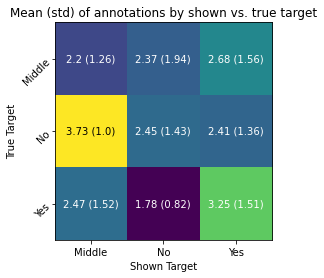

In [973]:
pivot_mean = pd.pivot_table(data, values='normalized_annotation', index='target', columns='shown_target', aggfunc=np.mean)
pivot_std = pd.pivot_table(data, values='normalized_annotation', index='target', columns='shown_target', aggfunc=np.std)
fig, ax = plt.subplots()
ax.imshow(pivot_mean.to_numpy())
ax.set_xticks(np.arange(len(pivot_mean.columns)))
ax.set_yticks(np.arange(len(pivot_mean.index)))
ax.set_xticklabels(pivot_mean.columns)
ax.set_yticklabels(pivot_mean.index)
ax.set_ylabel("True Target")
ax.set_xlabel("Shown Target")
ax.set_title("Mean (std) of annotations by shown vs. true target")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(pivot_mean.index)):
    for j in range(len(pivot_mean.columns)):
        text = ax.text(j, i, str(round(pivot_mean.to_numpy()[i, j], 2))+" ("+str(round(pivot_std.to_numpy()[i, j], 2))+")",
                       ha="center", va="center", color="w" if round(pivot_mean.to_numpy()[i, j], 2) < 3.5 else "black")

plt.show()

#### Observations:
As expected from our previous observations, if we show the target 'Yes' and it is also the true target, the quality of the rationale is fairly high. This again supports that the model is good at generating positive rationales as the shown target could not only correspond to a correct but also to a wrong prediction. 

If the model predicts 'in the middle' instead of the true target 'No' and we show the prediction to the annotator, the rating is extremely high (for our results). This could either result from the model being faithful (which we can't properly judge due to the annotators apparently disregarding the survey instructions) or again because of the model being better at generating positive rationales. 

Also high ratings were given to showing the wrong prediction 'Yes' instead of the true target. Again, the same reasoning can be applied of this either being due to high faithfulness in the rationales or because of the model having an easier time to generate positive rationales. 

Further, if a wrong prediction 'No' is shown instead of the true target 'Yes', the perceived quality of the rationales is extremely low. This could either be because wrong predictions 'No' do not work well with indirect answers that actually mean 'Yes' (and we suspect annotators do not solely evaluate faithfulness but also predictions) or because the model is mostly unable to produce proper negative rationales in this case.

On the contrary, if we show the wrong model prediction 'Yes' for a sample that actually has target 'No', the perceived quality of the rationales is roughly the same as when showing the true target no. However, we cannot draw the conclusion that this is due to the model being better at generating positive rationales as we have no way of evaluating how well the shown target 'Yes' is compatible with samples with true targets 'No' and in this graphic, the shown target 'No' can either be a correct prediction or the true target under an incorrect prediction and thus possibly a positive rationale. Further splitting the data would again result in too few annotations for conclusions.

The top left quadrant corresponds to the true target 'in the middle' being shown instead of a wrong prediction as we have seen before that there are no instances with correct predictions for 'in the middle'.

From the top row we can further observe that the model might indeed be better at generating positive rationales than negative ones as if the correct target is 'in the middle', showing rationales with the wrongly predicted target 'Yes' leads to a higher perceived rationale quality than showing rationales with the wrongly predicted label 'No'. However, it is not clear whether instances with true target 'in the middle' are more coherent when being paired with an incorrect target 'No' or incorrect target 'Yes'. This would require a separate human evaluation.

### We now look at annotations by true target vs. prediction if the correct target is shown:

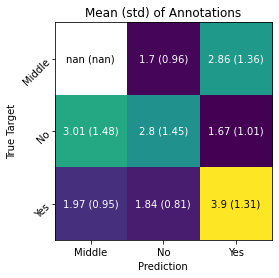

In [974]:
pivot_mean = pd.pivot_table(data[data['corr_target_shown'] == True], values='normalized_annotation', index='target', columns='prediction', aggfunc=np.mean)
pivot_std = pd.pivot_table(data[data['corr_target_shown'] == True], values='normalized_annotation', index='target', columns='prediction', aggfunc=np.std)
fig, ax = plt.subplots()
ax.imshow(pivot_mean.to_numpy())
ax.set_xticks(np.arange(len(pivot_mean.columns)))
ax.set_yticks(np.arange(len(pivot_mean.index)))
ax.set_xticklabels(pivot_mean.columns)
ax.set_yticklabels(pivot_mean.index)
ax.set_ylabel("True Target")
ax.set_xlabel("Prediction")
ax.set_title("Mean (std) of Annotations")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(pivot_mean.index)):
    for j in range(len(pivot_mean.columns)):
        text = ax.text(j, i, str(round(pivot_mean.to_numpy()[i, j], 2)) + " (" + str(round(pivot_std.to_numpy()[i, j], 2)) + ")",
                       ha="center", va="center", color="w" if round(pivot_mean.to_numpy()[i, j], 2) < 3.5 else "black")

plt.savefig("predicted_vs_true__target_shown.png", dpi=300, bbox_inches='tight')

#### Observations:
We notice that the perceived quality of rationales is significantly worse if we show the true target 'Yes' together with rationales that were generated alongside a wrong prediction. However, this does not indicate faithfulness as we would need to observe higher ratings if the prediction is shown instead of the true targets. For more, see the next graphic.

We again observe that correctly identified targets 'Yes' lead to higher rated rationales than correctly identified targets 'No'. This again shows that the model appears to be better at generating positive rationales.

Annotations for a wrongly predicted target 'in the middle' are perceived much better if the true target is 'No' than if the true target is 'Yes'. Especially considering that before we found that if the correct target is 'in the middle', showing rationales with the wrongly predicted target 'Yes' leads to a higher perceived rationale quality than showing rationales with the wrongly predicted label 'No', this result is surprising (we can also observe this in the top row). However, we are again unable to draw definite conclusions from this due to the inability to judge whether annotators rated faithfulness to the shown targets.

### The following graphic depicts annotations by true target vs. prediction if the prediction is shown:

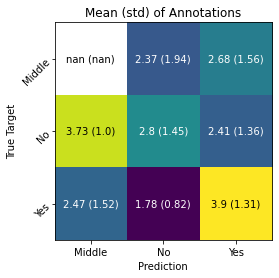

In [975]:
pivot_mean = pd.pivot_table(data.loc[(data['corr_target_shown'] == False) | (data['correct_pred'] == True)],
                                values='normalized_annotation',
                                index='target',
                                columns='prediction',
                                aggfunc=np.mean)
pivot_std = pd.pivot_table(data[data['corr_target_shown'] == False  | (data['correct_pred'] == True)], values='normalized_annotation', index='target', columns='prediction',
                           aggfunc=np.std)
fig, ax = plt.subplots()
ax.imshow(pivot_mean.to_numpy())
ax.set_xticks(np.arange(len(pivot_mean.columns)))
ax.set_yticks(np.arange(len(pivot_mean.index)))
ax.set_xticklabels(pivot_mean.columns)
ax.set_yticklabels(pivot_mean.index)
ax.set_ylabel("True Target")
ax.set_xlabel("Prediction")
ax.set_title("Mean (std) of Annotations")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(pivot_mean.index)):
    for j in range(len(pivot_mean.columns)):
        text = ax.text(j, i, str(round(pivot_mean.to_numpy()[i, j], 2)) + " (" + str(round(pivot_std.to_numpy()[i, j], 2)) + ")",
                       ha="center", va="center", color="w" if round(pivot_mean.to_numpy()[i, j], 2) < 3.5 else "black")
    
plt.savefig("predicted_vs_true__prediction_shown.png", dpi=300, bbox_inches='tight')

#### Observations:
We note that the ratings in the bottom left quadrant have significantly increased over showing the true target. This indicates that the model is faithful towards predictions 'in the middle' when the true target is 'Yes'. However the ratings in the bottom middle quadrant remain roughly the same as in case we show the true prediction. This could mean that there is no apparent faithfulness in case the model produces a wrong prediction 'No' for a true target 'Yes'. However, this could also result from the annotators not only considering the rationale quality towards the shown target but also the quality of the target. In this case, the shown target 'No' likely does not fit very well with the true target 'Yes'.

The quadrant corresponding to the prediction 'in the middle' and true target 'No' indicates that if the model is indeed better at generating positive rationales than negative ones, rationales for the prediction 'in the middle' are closer to positive rationales than to negative ones. 

Considering the graphic shown before, we can now make some rather definite conclusions regarding the model being better at generating positive rationales than negative ones. We have already observed that correctly predicted targets 'Yes' receive higher rationale ratings than correctly predicted targets 'No'. We now also see that if the model wrongly predicts the target 'No' instead of the true target 'Yes', the rationales are of higher quality if the true target 'Yes' is shown to the annotators. At the same time, if the model predicts the target 'Yes' instead of the true target 'No', the rationales are of higher quality if the wrong prediction 'Yes' is shown to the annotators. Both results combined rule out faithfulness as a possible reason for this.

We can make multiple interesting observations from the top row. First, we notice that if we show the model prediction instead of the true target 'in the middle', the perceived quality of rationales is higher for model prediction 'Yes' than for model prediction 'No'. From the previous graphic, we know that if the correct target is 'in the middle', showing rationales with the wrongly predicted target 'Yes' leads to a higher perceived rationale quality than showing rationales with the wrongly predicted label 'No'. Considering both graphics jointly, we see that if we switch from showing the true target to showing the model prediction, the perceived quality of rationales goes up for model predictions 'No' and goes down for model predictions 'Yes'. However, this again could be because annotators did not purely evaluate faithfulness towards the shown prediction but instead evaluated both prediction and rationale. If the model tends to produce rationales that are more fitting for polar labels instead of 'in the middle' and instances with true target 'in the middle' are conceptually closer to the target 'No' than to the target 'Yes', we would observe a similar behavior. This would however not explain why the ratings for rationales under a prediction 'Yes' are higher than the ones under a prediction 'No'. Most likely, there is a more complex interplay at action that we have not observed with the setup of our survey.

### Aggregation by correct prediction:

In [976]:
data.groupby(['correct_pred']).agg(
        {'annotation': ['mean', 'std', 'count'], 'normalized_annotation': ['mean', 'std', 'count']})

annotation                 normalized_annotation                
                   mean       std count                  mean       std count
correct_pred                                                                 
False          2.103825  1.368860   183              2.214789  1.297737   183
True           3.256410  1.509475   117              3.445006  1.470098   117

#### Observations:
Unsurprisingly, we note that if the model makes a correct prediction, the perceived quality of the rationales is higher than when the model makes a wrong prediction. This is mainly because in this case the whole output of the model fits to the input. Further, the annotators not purely evaluating faithfulness but also the prediction could play a role here. Lastly, we note that there have been no correct predictions for the label 'in the middle' and since we suspect that polar labels are easier to rationalize, this could play a further role in the results shown.

## Worker analysis

First, we look at how often the different ratings were selected:

In [977]:
data['annotation'].value_counts()

1    111
2     62
5     52
4     46
3     29
Name: annotation, dtype: int64

We calculate the normalized mean annotation:

In [978]:
data['normalized_annotation'].mean()

2.694573329020269

We calculate the unnormalized mean annotation:

In [979]:
data['annotation'].mean()

2.5533333333333332

We see the normalized mean is not too different from the unnormalized mean, which is what we expected.

For future reference (if we choose to make a follow-up survey), we now investigate the annotation time required:

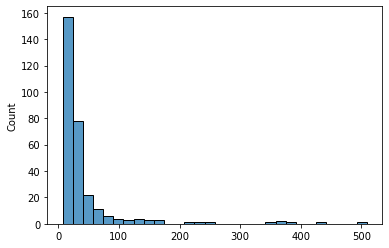

In [980]:
annotation_times = data['WorkTimeInSeconds'].to_numpy()
sns.histplot(annotation_times, bins=30)
plt.show()

We observe that most annotations take less than 100 seconds. Thus, we will treat all annotations which took more than 100 seconds as outliers and remove them from our further computations.

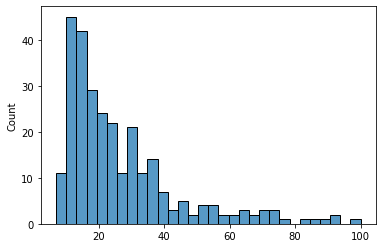

In [981]:
annotation_times = data[data['WorkTimeInSeconds'] <= 100]['WorkTimeInSeconds'].to_numpy()
sns.histplot(annotation_times, bins=30)
plt.show()

We calculate the 75th percentile and use that as a reference time for future annotations:

In [982]:
np.percentile(annotation_times, q=75)

32.0

We see that this roughly equals the initially stated 30 seconds of time that is required per annotation.

## Krippendorff's alpha:

To evaluate inter-worker aggreement, we use Krippendorff's alpha, which, in contrast to Cohen's beta, is able to consider missing values. In our dataset, missing values come in form of not every annotator having evaluated every sample.

We suspect that the Likert scale in our case is an interval scale, yet we report both the Krippendorff's alpha for nominal and interval scales.

In [983]:
agg_data = data.copy()
agg_data['dummy_id'] = agg_data['id'].astype(str) + agg_data['corr_target_shown'].astype(str)
agg_data = agg_data.pivot(index='WorkerId', columns='dummy_id', values='annotation')
agg_data = agg_data.fillna('*')
ka_nominal = krippendorff_alpha(agg_data.to_numpy(), nominal_metric, missing_items='*')
ka_interval = krippendorff_alpha(agg_data.to_numpy(), interval_metric, missing_items='*')
print(f"Krippendorff\'s alpha nominal: {ka_nominal}")
print(f"Krippendorff\'s alpha interval: {ka_interval}")

Krippendorff's alpha nominal: 0.17546278639950708
Krippendorff's alpha interval: 0.4576422082992134


We see that in the interval case, annotators tend to agree systematically which makes the survey results valid to be used for analysis. The nominal Krippendorff's alpha is significantly lower, but as our items in the Likert scale are at least ordinal, the nominal Krippendorff's alpha is less expressive.

## LAS Score

We now evaluate whether human evaluations roughly correspond to the scores whe have received from the leakage-adjusted simulatablility model.

For this, we first examine the pearson correlation coefficient between the normalized annotations and the LAS score, the simulator correctness based on input and explanation, the simulator correctness based on the explanation only and the simulator correctness based on the input only.

In [984]:
c_LAS = pearsonr(data['normalized_annotation'].to_numpy(), data['LAS_score'].to_numpy())
c_XE = pearsonr(data['normalized_annotation'].to_numpy(), data['XE_correct'].to_numpy())
c_E = pearsonr(data['normalized_annotation'].to_numpy(), data['E_correct'].to_numpy())
c_X = pearsonr(data['normalized_annotation'].to_numpy(), data['X_correct'].to_numpy())

print(f"corrcoeff (annotation, LAS_score): {c_LAS[0]:0.4f}  p: {c_LAS[1]:0.4f}")
print(f"corrcoeff (annotation, XE_correct): {c_XE[0]:0.4f}  p: {c_XE[1]:0.4f}")
print(f"corrcoeff (annotation, E_correct): {c_E[0]:0.4f}  p: {c_E[1]:0.4f}")
print(f"corrcoeff (annotation, X_correct): {c_X[0]:0.4f}  p: {c_X[1]:0.4f}")

corrcoeff (annotation, LAS_score): -0.0053  p: 0.9265
corrcoeff (annotation, XE_correct): 0.0947  p: 0.1015
corrcoeff (annotation, E_correct): 0.0511  p: 0.3774
corrcoeff (annotation, X_correct): 0.0815  p: 0.1592


It appears that the correlation is only minor, paired with high probabilities to observe that data under the null hypothesis of no correlation. We therefore replicate one of the analyses from the [LAS Paper](https://arxiv.org/abs/2010.04119) given in Table 6. 

In [985]:
print(data.groupby(['XE_correct']).agg({'normalized_annotation':['mean', 'std']}))
print(data.groupby(['X_correct']).agg({'normalized_annotation':['mean', 'std']}))
print(data.groupby(['E_correct']).agg({'normalized_annotation':['mean', 'std']}))

           normalized_annotation          
                            mean       std
XE_correct                                
False                   2.412470  1.404373
True                    2.765099  1.507151
          normalized_annotation          
                           mean       std
X_correct                                
False                  2.578005  1.477083
True                   2.820855  1.502051
          normalized_annotation          
                           mean       std
E_correct                                
False                  2.608655  1.452351
True                   2.762081  1.522605


In [986]:
print(linregress(data['XE_correct'].to_numpy(), data['normalized_annotation'].to_numpy()))
print()
print(linregress(data['X_correct'].to_numpy(), data['normalized_annotation'].to_numpy()))
print()
print(linregress(data['E_correct'].to_numpy(), data['normalized_annotation'].to_numpy()))

LinregressResult(slope=0.352628969507008, intercept=2.4124701534146626, rvalue=0.09472298701424281, pvalue=0.1015292079173724, stderr=0.2146828422390695)

LinregressResult(slope=0.24285017655924498, intercept=2.5780052442718313, rvalue=0.0814775796443099, pvalue=0.15922493293400716, stderr=0.17208610823295536)

LinregressResult(slope=0.1534258090765738, intercept=2.6086548759373875, rvalue=0.05114417521980431, pvalue=0.3773860433011088, stderr=0.1735503000377465)


We see that in principle the observations are comparable: there appear to be similar effects between the simulator accuracies and the annotations as reported in Table 5 of the LAS paper.

However, the magnitude of the coefficients when predicting the annotations from the accuracy of the simulators is different. While the authors of the LAS paper observe the highest coefficient for predicting annotations from simulator accuracy based on the explanation, we observe the highest coefficient when predicting from both input and explanation. At the same time, however, our $p$-values do not support definite conclusions, which again could be due to the very small number of annotations that are at our disposal.

# Conclusion

The analyses have shown trends in the model behavior of which we believe some to be systematic, such as the better performance on producing positive rationales over negative rationales and the model being faithful to (a subset of) its predictions. However, the very small number of annotations paired with the in hindsight insufficient information we have received from the annotators about the qualities of a shown sample keep us short of making any definite conclusions. 

As most of the observations made here are either not robust enough or irrelevant towards our original research question, we decided to exclude them from our project report in order to keep the focus on results we can draw actual conclusions from.

For future work, we should re-design the setup of the Mechanical Turk survey to obtain more reliable data.